In [68]:
import numpy as np
from qiskit.circuit import QuantumCircuit
from qiskit_algorithms import EstimationProblem
from qiskit.primitives import Sampler
from qiskit_algorithms import AmplitudeEstimation, IterativeAmplitudeEstimation, MaximumLikelihoodAmplitudeEstimation, FasterAmplitudeEstimation

import matplotlib.pyplot as plt
import pandas as pd

from qiskit import transpile

In [2]:
# Experiment Setup
p = 0.2

In [3]:
class BernoulliA(QuantumCircuit):
    """A circuit representing the Bernoulli A operator."""

    def __init__(self, probability):
        super().__init__(1)  # circuit on 1 qubit

        theta_p = 2 * np.arcsin(np.sqrt(probability))
        self.ry(theta_p, 0)


In [4]:
class BernoulliQ(QuantumCircuit):
    """A circuit representing the Bernoulli Q operator."""

    def __init__(self, probability):
        super().__init__(1)  # circuit on 1 qubit

        self._theta_p = 2 * np.arcsin(np.sqrt(probability))
        self.ry(2 * self._theta_p, 0)

    def power(self, k):
        # implement the efficient power of Q
        q_k = QuantumCircuit(1)
        q_k.ry(2 * k * self._theta_p, 0)
        return q_k

In [5]:
A = BernoulliA(p)
Q = BernoulliQ(p)

# Canonical AE


In [18]:
problem = EstimationProblem(
    state_preparation=A,  # A operator
    grover_operator=Q,  # Q operator
    objective_qubits=[0],  # the "good" state Psi1 is identified as measuring |1> in qubit 0
)

In [19]:
sampler = Sampler()

In [20]:
#  QAE implementation by Brassard et al. 

ae = AmplitudeEstimation(
    num_eval_qubits=3,  # the number of evaluation qubits specifies circuit width and accuracy
    sampler=sampler,
)

ae_result = ae.estimate(problem)

In [21]:
print(ae_result.estimation)

0.1464466


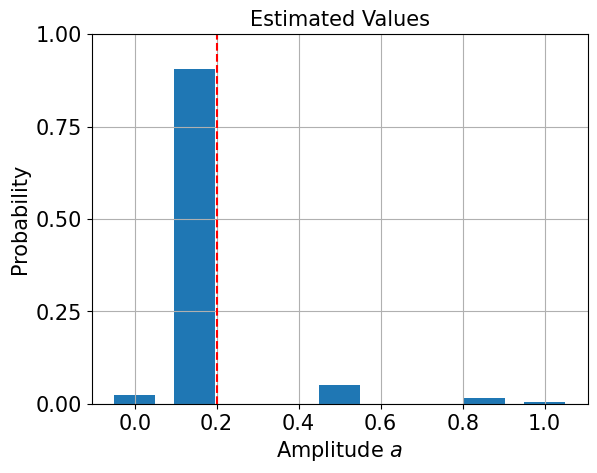

In [22]:
# plot estimated values
gridpoints = list(ae_result.samples.keys())
probabilities = list(ae_result.samples.values())

plt.bar(gridpoints, probabilities, width=0.5 / len(probabilities))
plt.axvline(p, color="r", ls="--")
plt.xticks(size=15)
plt.yticks([0, 0.25, 0.5, 0.75, 1], size=15)
plt.title("Estimated Values", size=15)
plt.ylabel("Probability", size=15)
plt.xlabel(r"Amplitude $a$", size=15)
plt.ylim((0, 1))
plt.grid()
plt.show()

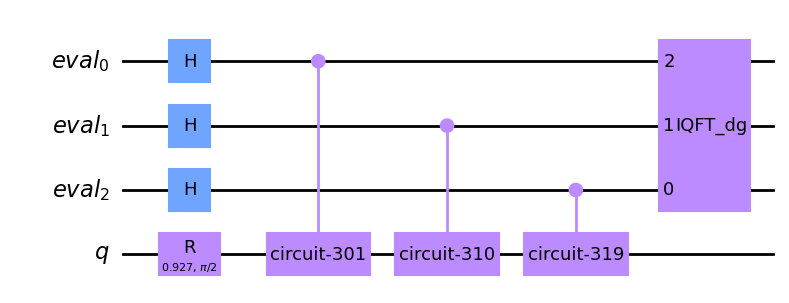

In [23]:
ae_circuit = ae.construct_circuit(problem)
ae_circuit.decompose().draw(
    "mpl", style="clifford"
)

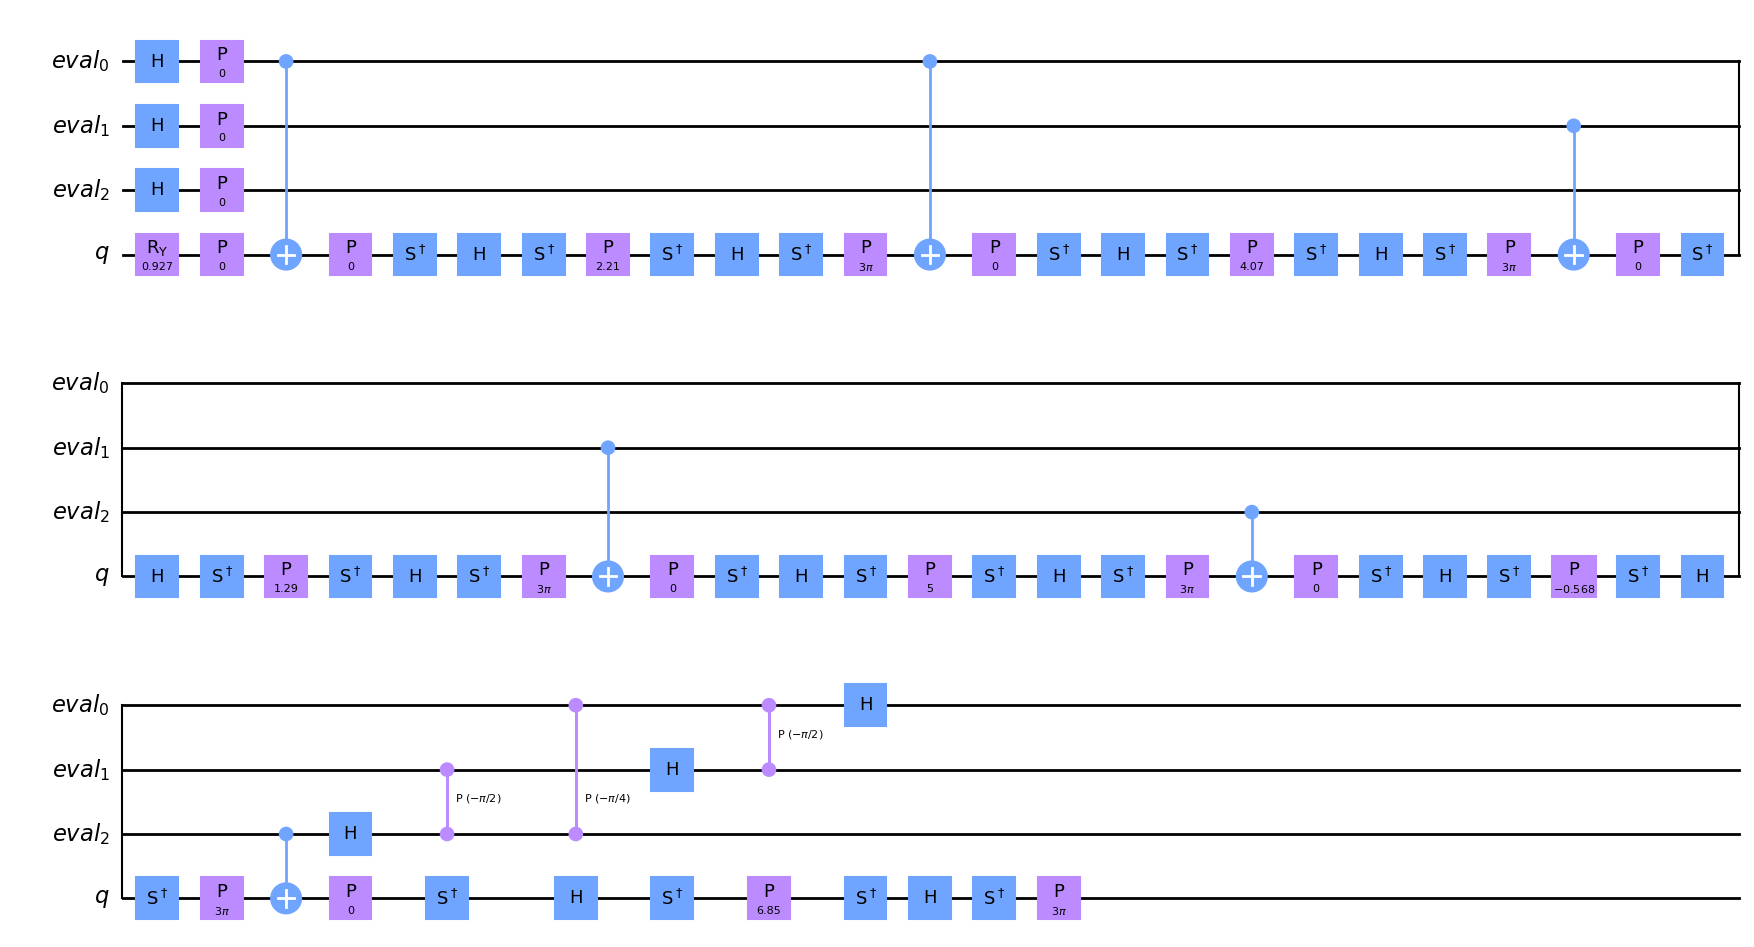

In [24]:
basis_gates = ["h", "ry", "cry", "cx", "ccx", "p", "cp", "x", "s", "sdg", "y", "t", "cz"]
transpile(ae_circuit, basis_gates=basis_gates, optimization_level=2).draw("mpl", style="clifford")

# Iterative Amplitude Estimation

In [37]:
iae = IterativeAmplitudeEstimation(
    epsilon_target=0.01,  # target accuracy
    alpha=0.05,  # width of the confidence interval
    sampler=sampler,
)
iae_result = iae.estimate(problem)

print("Estimate:", iae_result.estimation)

Estimate: 0.2


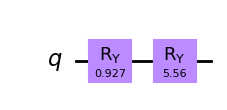

In [58]:
iae_circuit = iae.construct_circuit(problem, k=3)
iae_circuit.draw("mpl", style="clifford")

# Maximum Likelihood Amplitude Estimation

In [59]:
mlae = MaximumLikelihoodAmplitudeEstimation(
    evaluation_schedule=3,  # log2 of the maximal Grover power
    sampler=sampler,
)
mlae_result = mlae.estimate(problem)

print("Estimate:", mlae_result.estimation)

Estimate: 0.20002237175368104


In [60]:
mlae_circuit = mlae.construct_circuits(problem) # creates a list of 4 circuits, one for each of the evaluation schedules


# Faster Amplitude Estimation

In [36]:
fae = FasterAmplitudeEstimation(
    delta=0.01,  # target accuracy
    maxiter=3,  # determines the maximal power of the Grover operator
    sampler=sampler,
)
fae_result = fae.estimate(problem)

print("Estimate:", fae_result.estimation)

Estimate: 0.19979485940974964


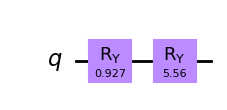

In [61]:
fae_circuit = fae.construct_circuit(problem, k =3)
fae_circuit.draw("mpl", style="clifford")

In [86]:
results = {
    "Canonical AE" : (ae_circuit, ae_result),
    "Iterative Amplitude Estimation": (iae_circuit, iae_result),
    "Maximum Likelihood Amplitude Estimation": (mlae_circuit, mlae_result),
    "Faster Amplitude Estimation": (fae_circuit, fae_result)  
}

In [80]:
def abs_error(m1,m2):
    return abs(m1 - m2)

def relative_error(m1,m2):
    return abs_error(m1,m2)/abs(m1)

def mse(m1,m2):
    return (m2 - m1) ** 2

In [88]:
def circuits_to_dataframe(circuits_dict):
    data = []
    
    for name, data_circuit in circuits_dict.items():
        qc = data_circuit[0]
        if not isinstance(qc, list):
            num_qubits = qc.num_qubits
            num_clbits = qc.num_clbits
            depth = qc.depth()
            samples = 1
        else:
            num_qubits = 0
            num_clbits = 0
            depth_list = []
            samples = len(qc)
            for circuit in qc:
                num_qubits += circuit.num_qubits
                num_clbits += circuit.num_clbits
                depth_list.append(circuit.depth())
                
            depth = max(depth_list)
                
            
        
        result = data_circuit[1].estimation
    
        
        # Store all data in a row
        row = {"Circuit Name": name, "Samples": samples,"Qubits": num_qubits, "Classical Bits": num_clbits, "Depth": depth, "Estimated Value": result, 'Absolute Error': abs_error(p, result), 'Relative Error': relative_error(p, result), 'MSE': mse(p, result)}
        data.append(row)
    
    # Convert to DataFrame
    df = pd.DataFrame(data)
    
    return df

In [89]:
df = circuits_to_dataframe(results)

# Display DataFrame
print(df)

                              Circuit Name  Samples  Qubits  Classical Bits  \
0                             Canonical AE        1       4               0   
1           Iterative Amplitude Estimation        1       1               0   
2  Maximum Likelihood Amplitude Estimation        4       4               0   
3              Faster Amplitude Estimation        1       1               0   

   Depth  Estimated Value  Absolute Error  Relative Error           MSE  
0      2         0.146447        0.053553        0.267767  2.867967e-03  
1      2         0.200000        0.000000        0.000000  0.000000e+00  
2      2         0.200022        0.000022        0.000112  5.004954e-10  
3      2         0.199795        0.000205        0.001026  4.208266e-08  
